## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [273]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [274]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

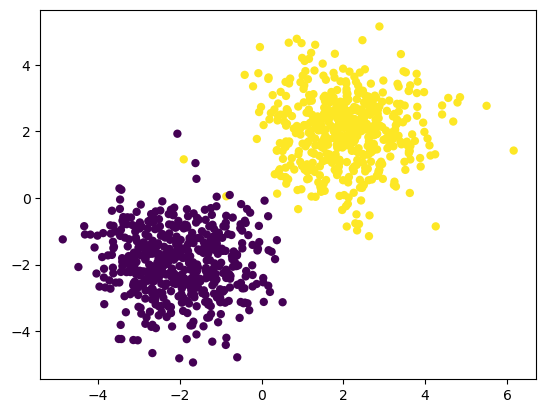

In [275]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [277]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [278]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [279]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

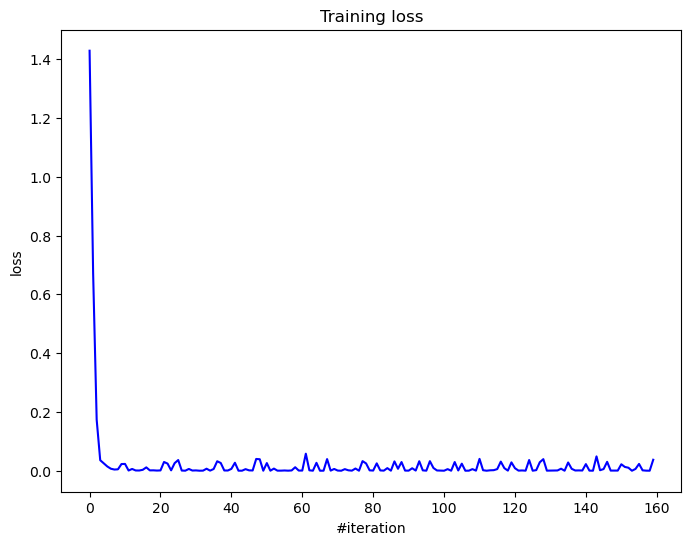

Current loss: 0.037300


In [280]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [283]:
import sys
import os

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [284]:

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [285]:
X_train = X_train.squeeze()
X_val = X_val.squeeze()
X_test = X_test.squeeze()

In [244]:
# import mnist
# X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [286]:
X_train.shape, y_train.shape # ((50000, 28, 28), (50000,))

((50000, 28, 28), (50000,))

In [287]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense()) 
y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense()) 
y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()) 

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

In [288]:
X_train.shape, y_train.shape # ((50000, 784), (50000, 10))

((50000, 784), (50000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [281]:
# Your code goes here. ################################################

def train(net, optimizer):
    history_loss = []
    for _ in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)
            history_loss.append(loss) 
    return history_loss

## ReLU

In [249]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu = train(net, sgd_momentum)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



CPU times: user 1min 45s, sys: 29.7 s, total: 2min 15s
Wall time: 19.7 s


## ELU

In [250]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_elu = train(net, sgd_momentum)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 53s, sys: 26.4 s, total: 2min 19s
Wall time: 21 s


## LeakyReLU

In [251]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu_l = train(net, sgd_momentum)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 37s, sys: 35.4 s, total: 2min 13s
Wall time: 18.5 s


## SoftPlus

In [252]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_soft_plus = train(net, sgd_momentum)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 41s, sys: 33.7 s, total: 2min 14s
Wall time: 19 s


## ReLU + BatchNormalization

In [253]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 2min 3s, sys: 22.2 s, total: 2min 25s
Wall time: 22.5 s


## ELU + BatchNorm

In [254]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_elu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ELU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 56s, sys: 27.3 s, total: 2min 23s
Wall time: 21.4 s


## LeakyReLU + BatchNorm

In [255]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_l_Relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 46s, sys: 29.7 s, total: 2min 15s
Wall time: 19.5 s


## SoftPlus + BatchNorm

In [256]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_softplus = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 41s, sys: 33.7 s, total: 2min 14s
Wall time: 18.8 s


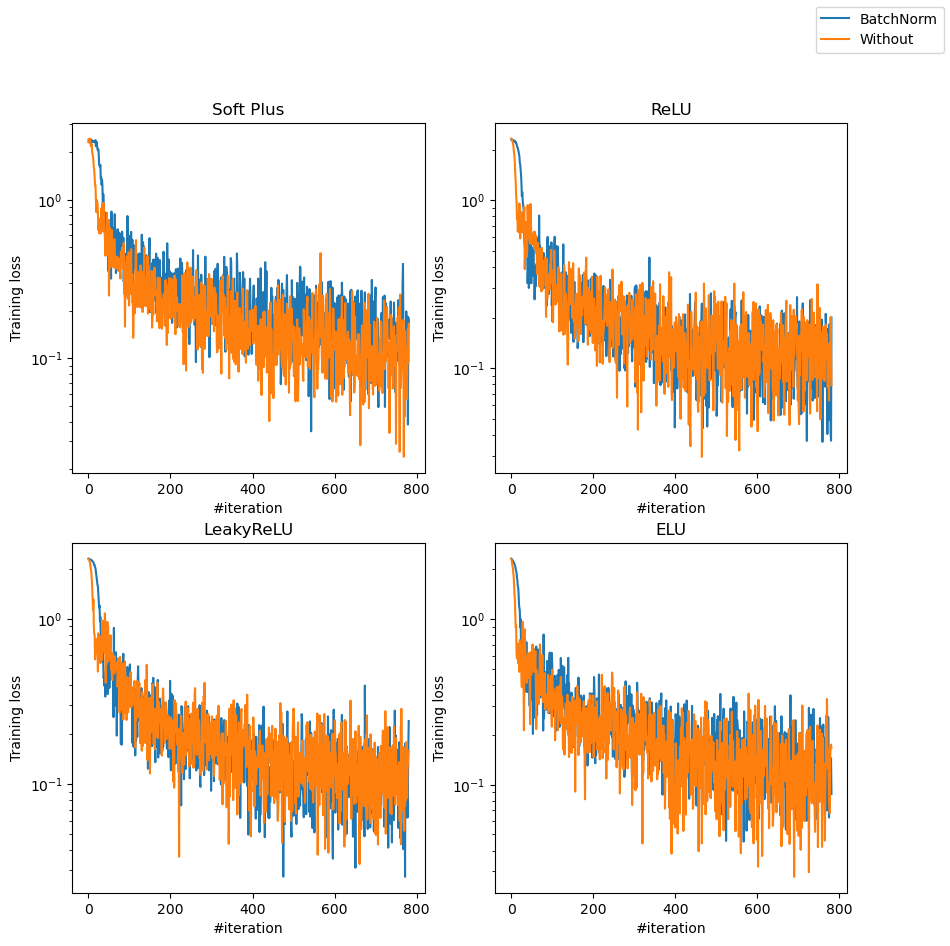

In [257]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].semilogy(loss_history_batchn_softplus, label='BatchNorm')
axs[0, 0].semilogy(loss_history_soft_plus, label='Without')
axs[0, 0].set_title('Soft Plus')

axs[0, 1].semilogy(loss_history_batchn_relu)
axs[0, 1].semilogy(loss_history_relu)
axs[0, 1].set_title('ReLU')

axs[1, 0].semilogy(loss_history_batchn_l_Relu)
axs[1, 0].semilogy(loss_history_relu_l)
axs[1, 0].set_title('LeakyReLU')

axs[1, 1].semilogy(loss_history_batchn_elu)
axs[1, 1].semilogy(loss_history_elu)
axs[1, 1].set_title('ELU')

for ax in axs.flat:
    ax.set(xlabel='#iteration', ylabel='Training loss')
fig.legend();

## Adam Oprimizer

In [258]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
loss_history_adam_relu = train(net, adam_optimizer)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 33s, sys: 35.8 s, total: 2min 9s
Wall time: 17.9 s


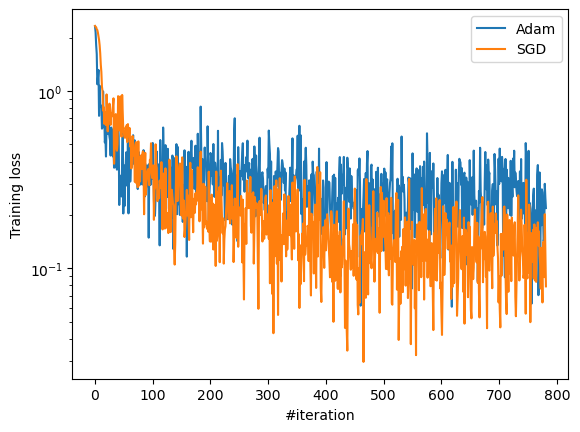

In [259]:
plt.semilogy(loss_history_adam_relu, label='Adam')
plt.semilogy(loss_history_relu, label='SGD')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend();

In [260]:
loss_history_adam_relu[-1] # 0.2994484636793639

0.2185360913432257

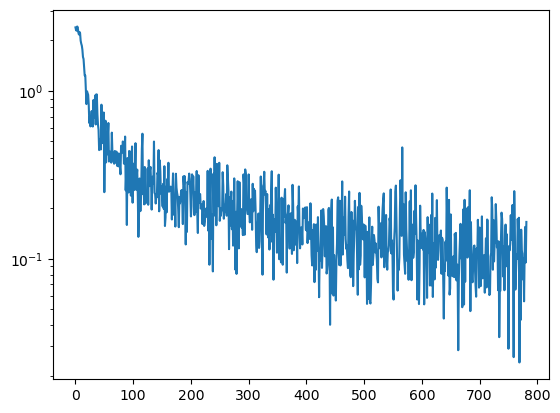

In [261]:
plt.semilogy(loss_history_soft_plus, label='Soft Plus')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [262]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [264]:
# Your code goes here. ################################################

Linear 784 -> 784
BatchNormalization
ReLU
Linear 784 -> 392
BatchNormalization
Linear 392 -> 10
Dropout
Linear 10 -> 10
LogSoftMax

CPU times: user 9min 22s, sys: 15min 31s, total: 24min 53s
Wall time: 3min 20s


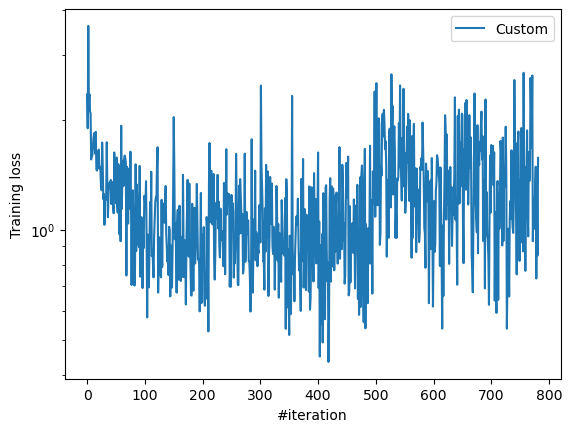

In [289]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, image_size))
net.add(BatchNormalization())
net.add(ReLU())
net.add(Linear(image_size, image_size // 2))
net.add(BatchNormalization())
net.add(Linear(image_size // 2, output_size))
net.add(Dropout(0.4))
net.add(Linear(output_size, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
loss_history = train(net, adam_optimizer)
plt.semilogy(loss_history, label='Custom')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend()

Print here your accuracy on test set. It should be around 90%.

In [290]:
# Your answer goes here. ################################################
net.evaluate()

n_preds = len(y_test)
predictions = net.forward(X_test)
b = np.zeros_like(predictions)
b[np.arange(len(predictions)), predictions.argmax(1)] = 1
print(b)
print(y_test)

print("Accuracy: ", np.sum(b == y_test) / n_preds / 10)


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Accuracy:  0.9787399999999999


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [291]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
import random
from matplotlib import pyplot as plt
import os

device = torch.device('mps') # uncomment for mac m1

In [292]:
class NN(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.BatchNorm1d(input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape // 2),
            nn.BatchNorm1d(input_shape // 2),
            nn.Linear(input_shape // 2, num_classes),
            nn.Dropout(0.4),
            nn.Linear(num_classes, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, input):       
        out = self.model(input)
        return out

In [293]:
def gimme_loss_and_correct(model, loss_func, X, y):
    outputs = model(X)
    loss = loss_func(outputs, y)
    values, idx = torch.max(outputs, 1)
    correct = (idx == y).sum().item()
    return loss.item(), correct

In [294]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


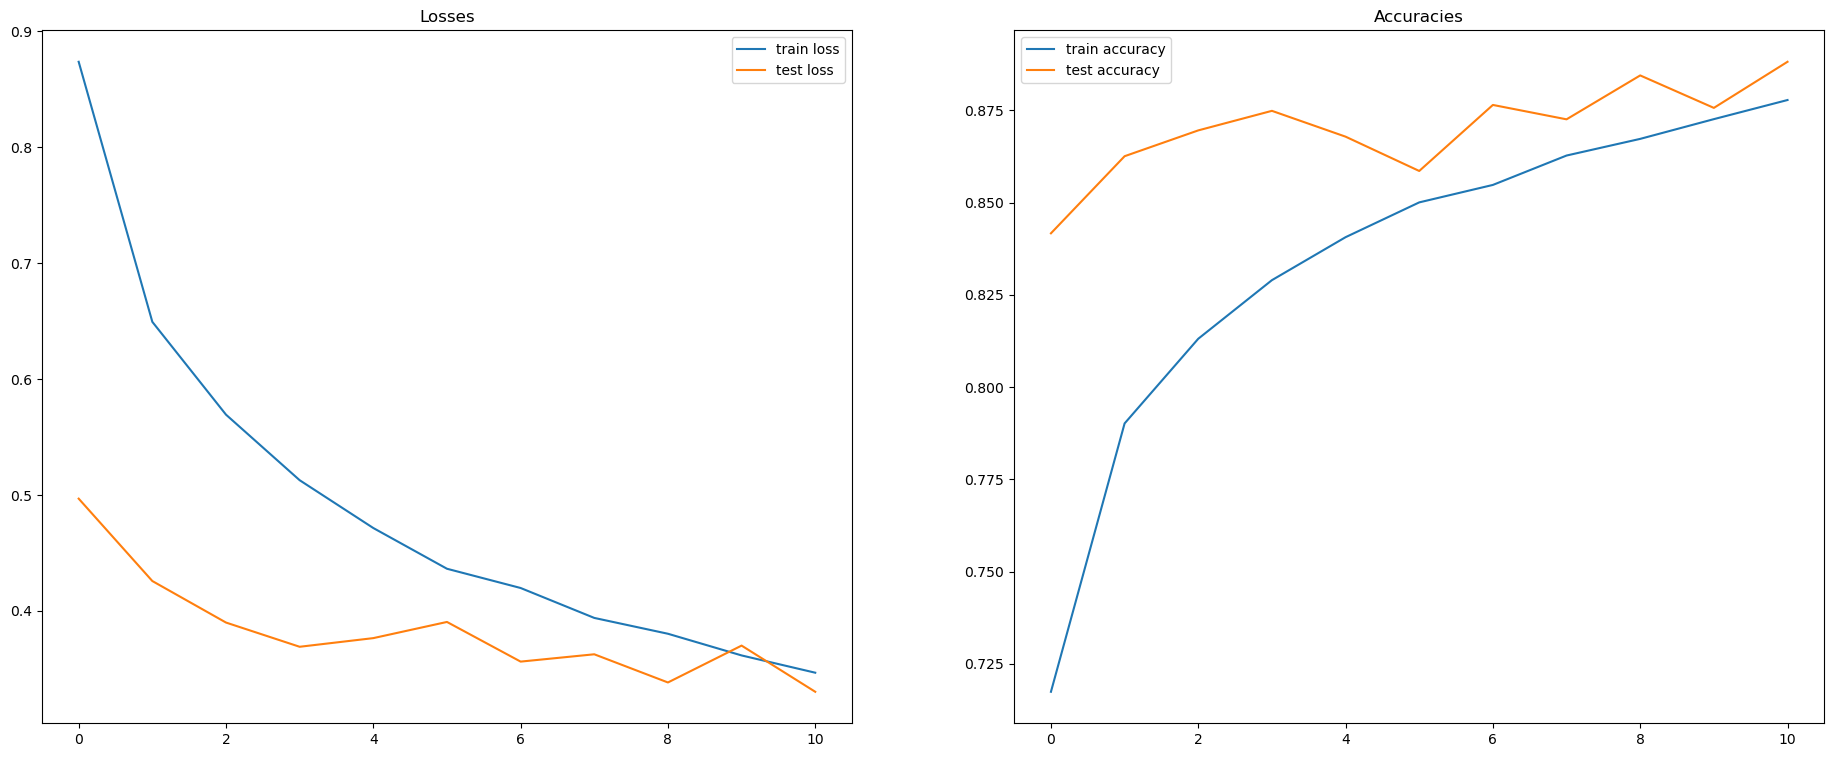

In [295]:
model = NN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
root_path = 'fmnist'
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

loss_func = nn.CrossEntropyLoss()

test_accuracy = 0.0
train_accuracy = 0.0
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []
while test_accuracy < 0.885:
    model.train()
    train_loss = 0.0
    train_correct = 0

    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        opt.zero_grad()
        outputs = model(X_train)
        loss = loss_func(outputs, y_train)
        loss.backward()
        opt.step()
        train_loss += loss.item()
        values, idx = torch.max(outputs, 1)
        train_correct += (idx == y_train).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    tt = 0
    test_loss = 0.0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        l, c = gimme_loss_and_correct(model=model, loss_func=loss_func, X=X_test, y=y_test)
        test_loss += l
        correct += c
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = correct / len(fmnist_dataset_test)
    test_accuracies.append(test_accuracy)

fig, (p1, p2) = plt.subplots(1, 2, figsize=(23, 9))

p1.set_title('Losses')
p1.plot(train_losses, label='train loss')
p1.plot(test_losses, label='test loss')
p1.legend()

p2.set_title('Accuracies')
p2.plot(train_accuracies, label='train accuracy')
p2.plot(test_accuracies, label='test accuracy')
p2.legend()